In [36]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



In [37]:
import utils.data67_processing as dp
from utils.UNeXt import UNet
from utils.loss import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [39]:
device


device(type='cuda', index=0)

# Build dataset

In [40]:
# Dataset
directory  = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
directory  = '/net/projects/CLS/force_reference/data/ZyxAct_16kPa_small/'

test_cells = 'cell_1'


in_channels  = [[7]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (6)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

In [41]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [42]:
df = dataset.info.copy()

df.head(10)

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_0,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
1,cell_0,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
2,cell_0,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
3,cell_0,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
4,cell_0,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
5,cell_0,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
6,cell_0,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
7,cell_0,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
8,cell_0,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
9,cell_0,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164


In [43]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_1']}
[361 474 448 465 453 375 470 459 402 406 401 377 378 417 445 382 475 427
 440 420 371 369 403 384 387 478 400 428 399 412 424 444 389 449 429 436
 395 383 462 464 425 411 415 413 362 433 461 392 360 376 430]


In [44]:
dataset.info

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_0,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
1,cell_0,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
2,cell_0,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
3,cell_0,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
4,cell_0,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,5.212261,129.156811,76.050815,509.421164
...,...,...,...,...,...,...,...,...,...,...
475,cell_1,Disp_Trac_CellMask_ForceMask_Actin_115.npy,115,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,4.430032,28.235241,29.364622,306.488766
476,cell_1,Disp_Trac_CellMask_ForceMask_Actin_116.npy,116,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,4.430032,28.235241,29.364622,306.488766
477,cell_1,Disp_Trac_CellMask_ForceMask_Actin_117.npy,117,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,4.430032,28.235241,29.364622,306.488766
478,cell_1,Disp_Trac_CellMask_ForceMask_Actin_118.npy,118,/net/projects/CLS/force_reference/data/ZyxAct_...,0.0,0.0,4.430032,28.235241,29.364622,306.488766


In [45]:
cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

365


In [46]:
dataset.out_channels


6

In [47]:
sample = dataset[idx]

{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


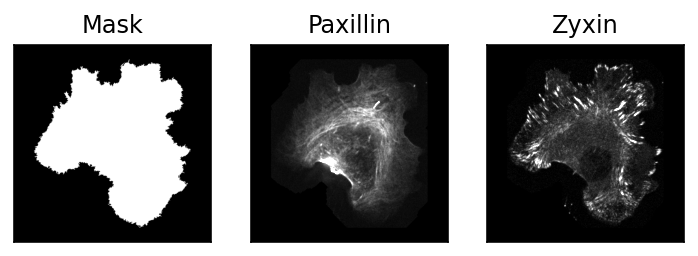

In [48]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Paxillin')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=20, vmin=0)
ax[2].set_title('Zyxin')
ax[2].imshow(sample['output'].squeeze(), origin='lower', cmap='gray', vmax=20, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [49]:
sample

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'zyxin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'actin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'output': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.

# Build U-Net model with ConvNext blocks

In [50]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'am',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['actin1','actin2']:
    modelname = 'model_77to66_100ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}


UNet(
  (layers_encode): ModuleList(
    (0): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
        (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (4): DownsampleLayer(
        (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
    )
    (1): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
        (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(8, eps=

# Perform training

In [54]:
save_models = True
n_epochs = 150

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))

    # SAVE
    if save_models:
        # Log in tensorboard
        # for mkey in models.keys():
        #     model[mkey].log_images(epoch=e)
        #     model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


IndentationError: unexpected indent (133077794.py, line 12)

# Plot prediction on train cell

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_3'
frame = 0

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=20, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=300, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_2'
frame = 0

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=300, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1000, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])